In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print ("---Train---")
    print ("Precision: %.4f" % (precision_score(y_train, y_train_pred)))
    print ("Recall: %.4f" % (recall_score(y_train, y_train_pred)))
    print ("F1: %.4f" % (f1_score(y_train, y_train_pred)))
    print ("Confusion matrix:")
    print (confusion_matrix(y_train, y_train_pred))
    print ("\n---Test---")
    print ("Precision: %.4f" % (precision_score(y_test, y_test_pred)))
    print ("Recall: %.4f" % (recall_score(y_test, y_test_pred)))
    print ("F1: %.4f" % (f1_score(y_test, y_test_pred)))
    print ("Confusion matrix:")
    print (confusion_matrix(y_test, y_test_pred))

def aucpr(y_true, y_score):
    precision, recall, threshold = precision_recall_curve(y_true, y_score)
    indices = np.argsort(precision)
    precision = precision[indices]
    recall = recall[indices]
    plt.plot(recall, precision, '.')
    plt.show()
    return auc(precision, recall)

In [3]:
class MultiVariateNormal(object):
    
    def __init__(self, data):
        self.mu = np.mean(data, axis=0)
        self.sigma = np.cov(data.T)
        self.model = multivariate_normal(mean=self.mu, cov=self.sigma)

    def predict(self, sample):
        return self.model.pdf(sample)

In [4]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', header=None)[0]
y_test = pd.read_csv('data/y_test.csv', header=None)[0]
X_train.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test.drop(['Time', 'Amount'], axis=1, inplace=True)

## Drop features from Feature Engineering

In [5]:
X_train.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1, inplace=True)
X_test.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1, inplace=True)

## Construct training and test set

In [6]:
normal_indices = y_train[y_train==0].index
fraud_indices = y_train[y_train==1].index
# training set contains only normal
normal_X_train = X_train.iloc[normal_indices, :]
# test sert contains a part of normal and all fraud
fraud_X_train = X_train.iloc[fraud_indices, :]
X_test = pd.concat([X_test, fraud_X_train])
y_test = pd.concat([y_test, y_train[y_train==1]])

In [7]:
mn = MultiVariateNormal(normal_X_train)
y_test_score = mn.predict(X_test)

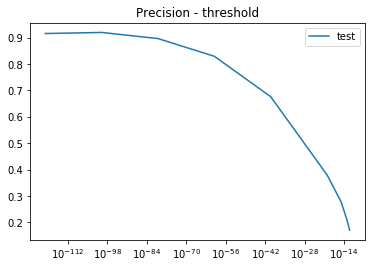

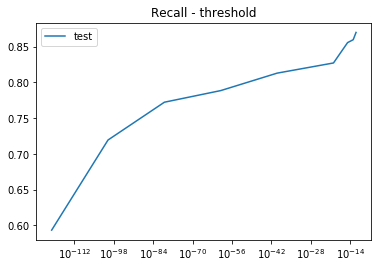

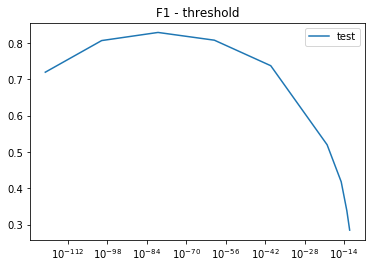

In [8]:
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
thresholds = [1e-120, 1e-100, 1e-80, 1e-60, 1e-40, 1e-20, 1e-15, 1e-13, 1e-12]
for threshold in thresholds:
    y_test_pred = np.array([sc<=threshold for sc in y_test_score], dtype=int)
    
    test_prec.append(precision_score(y_test, y_test_pred))
    test_rec.append(recall_score(y_test, y_test_pred))
    test_f1.append(f1_score(y_test, y_test_pred))
    
plt.semilogx(thresholds, test_prec, label='test')
plt.title("Precision - threshold")
plt.legend()
plt.show()
    
plt.semilogx(thresholds, test_rec, label='test')
plt.title("Recall - threshold")
plt.legend()
plt.show()    

plt.semilogx(thresholds, test_f1, label='test')
plt.title("F1 - threshold")
plt.legend()
plt.show()